# BAL Pseudobulk Part 3
Filtering and analysis of DEGs.

In [1]:
import os
import re
import math
import upsetplot
import collections
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import adjustText as adjust_text

## Read in data

In [2]:
data_dir = "/projects/b1038/Pulmonary/cpuritz/PASC/data"

In [3]:
v = "GEO_v2"
adata = sc.read_h5ad(f"{data_dir}/01BAL/01integrated_BAL_{v}/01integrated_BAL_{v}.h5ad")
adata_raw = sc.read_h5ad(f"{data_dir}/01BAL/raw/adata_raw_{v}.h5ad")

In [4]:
cell_map = pd.read_csv(f"{data_dir}/01BAL/DEG/counts/cell_names.csv")

## Plotting functions
### Plot mean gene expression for top up and downregulated DEGs

In [5]:
def plot_heatmap(degs, cell_name, cell_type, meta, out_dir, fname, ngenes = 25):
    val_counts = degs.sign.value_counts(dropna = False)
    num_top = min(ngenes, val_counts.get("Upregulated", 0))
    num_bot = min(ngenes, val_counts.get("Downregulated", 0))
    genes = degs.loc[degs.padj <= 0.05, :].index[list(range(num_top)) + list(range(-num_bot, 0))]
    
    if num_top + num_bot == 0:
        return
    
    markers_expr = []
    ad_slice = adata[adata.obs.cell_type == cell_name, :]
    ad_slice = ad_slice[ad_slice.obs.Study_ID.isin(meta.index), :]
    clusters = sorted(ad_slice.obs.Study_ID.unique())
    gene_ix = ad_slice.raw.var_names.isin(genes)
    for g in clusters:
        mean_exp = ad_slice.raw.X[ad_slice.obs.Study_ID == g, :][:, gene_ix].mean(axis = 0).A.reshape(-1)
        markers_expr.append(mean_exp)
        
    markers_expr = pd.DataFrame(markers_expr,
                                index = clusters,
                                columns = ad_slice.raw.var_names[ad_slice.raw.var_names.isin(genes)])
    # Standard-scale expression
    markers_expr = (markers_expr - markers_expr.min()) / (markers_expr.max() - markers_expr.min())

    axes = sns.clustermap(markers_expr.loc[:, genes].T.to_numpy(),
                          row_cluster = False,
                          cmap = "inferno",
                          dendrogram_ratio = 0.1,
                          cbar_kws = {"ticks": []},
                          linecolor = "none",
                          snap = True,
                          figsize = (14, 10))
    
    # Set x- and y-axis tick marks
    ax = axes.ax_heatmap
    ax.set_yticks(pd.Series(range(len(genes))) + 0.5)
    ax.set_yticklabels(list(genes), fontstyle = "italic", fontsize = 12, rotation = 0)
    ax.tick_params(left = True, labelleft = True, right = False, labelright = False)
    ax.set_xticks(pd.Series(range(len(clusters))) + 0.5)
    ax.set_xticklabels([clusters[x] for x in axes.dendrogram_col.reordered_ind],
                       rotation = 45,
                       ha = "right",
                       fontsize = 12)
    
    # Adjust size of heatmap and size/position of colorbar
    ax.figure.subplots_adjust(0.19, 0.12, 0.76, 0.9)
    axes.cax.set_position((0.73, 0.91, 0.015, 0.055))
    
    # Move x-axis labels to the right
    trans = mpl.transforms.Affine2D().translate(10, 0)
    for t in ax.get_xticklabels():
        t.set_transform(t.get_transform() + trans)

    # Add a title, and label the colorbar
    ax.figure.text(0.2, 0.96, cell_name, va = "top", fontsize = 18)
    axes.cax.annotate("row min.", (-1.5, -0.1), va = "top", annotation_clip = False, fontsize = 12)
    axes.cax.annotate("row max.", (-1.5, 1.1), va = "bottom", annotation_clip = False, fontsize = 12)

    # Save heatmap
    ax.figure.savefig(f"{out_dir}/{fname}.pdf")
    plt.close(ax.figure)

### MA plots

In [6]:
def plot_ma(degs, cell_name, cell_type, meta, out_dir, fname, ngenes = 25):
    fig, ax = plt.subplots()
    val_counts = degs.sign.value_counts(dropna = False).sort_index()
    num_top = min(ngenes, val_counts.get("Upregulated", 0))
    num_bot = min(ngenes, val_counts.get("Downregulated", 0))
    genes = degs.loc[degs.padj <= 0.05, :].index[list(range(num_top)) + list(range(-num_bot, 0))]
    
    sign_cells = gene_cells.loc[degs.index[degs.sign != ""], :].sum(axis = 1)
    min_cells = sign_cells.min()
    max_cells = sign_cells.max()
    colors = {"": "gray",
              "Upregulated": lambda x: gene_cells.loc[x.index, :].sum(axis = 1),
              "Downregulated": lambda x: gene_cells.loc[x.index, :].sum(axis = 1)}
    cmap = {"": None,
            "Upregulated": mpl.cm.winter_r,
            "Downregulated": mpl.cm.autumn_r}
    alphas = {"": 0.2,
              "Upregulated": 1,
              "Downregulated": 1}
    labels = {"": "",
              "Upregulated": "Upregulated",
              "Downregulated": "Downregulated"}
        
    processed = []
    for k, v in val_counts.items():
        idx = degs.sign == k
        kwargs = {}
        label = labels[k]
        if label:
            label = f"{label} ({idx.sum()})"
        kwargs["label"] = label
        c = colors[k]
        if callable(c):
            c = c(degs[idx])
            kwargs["norm"] = mpl.colors.LogNorm(vmin = min_cells, vmax = max_cells)
        kwargs["c"] = c
        kwargs["alpha"] = alphas[k]
        if cmap.get(k):
            kwargs["cmap"] = cmap[k]
        dots = ax.scatter(degs.baseMean[idx], 
                          degs.log2FoldChange[idx],
                          s = 4,
                          **kwargs)
        if kwargs.get("norm"):
            fig.colorbar(dots, label = "No of cells with gene")
            processed.append(k)
        
    ax.set_xscale("log")
    ax.figure.set_size_inches(8, 6)
    ax.set_title(cell_name)
    ax.set_ylabel("$log_2$(fold change)", size = 16)
    ax.set_xlabel("Mean expression", size = 16)
    if len(processed) > 0:
        l = ax.legend(fontsize = 12, markerscale = 4)
        for lh in l.legend_handles: 
            lh.set_alpha(1)
    fig.axes[0].set_position((0.1, 0.1, 0.72, 0.85))
    for i, d in enumerate(processed):
        if d == "Downregulated":
            fig.axes[i + 1].set_position((0.84, 0.52, 0.08, 0.375))
        else:
            fig.axes[i + 1].set_position((0.84, 0.12, 0.08, 0.375))
    
    texts = []
    for r in degs.loc[genes, :].itertuples(name = None):
        texts.append(ax.text(r[1], r[2], r[0], size = 9))
    if len(texts) > 0:
        adjust_text.adjust_text(texts, ax = ax, autoalign = False,
                                expand_points = (1.5, 1.5), force_points = (1, 1),
                                arrowprops = dict(arrowstyle = '-', color = 'black', shrinkA = 4, shrinkB = 4))

    # Save plot
    fig.savefig(f"{out_dir}/{fname}.pdf")
    plt.close(fig)

### Upset plots

In [7]:
def make_upset_plots(celltypes, name):
    udir = f"{data_dir}/01BAL/DEG/output/upset"
    ct_degs = {"up": {}, "down": {}}
    for ct in celltypes:
        degs = data[ct]["filtered_degs"]
        ct_degs["up"][ct] = degs.index[degs.sign.eq("Upregulated")].tolist()
        ct_degs["down"][ct] = degs.index[degs.sign.eq("Downregulated")].tolist()

    intr = upsetplot.from_contents(ct_degs["up"])
    if intr.shape[0] > 0:
        intr.to_csv(f"{udir}/{name}_upregulated_degs.csv")
        p = upsetplot.UpSet(intr, show_counts = True).plot()
        p["intersections"].set_title(f"{name} Upregulated DEGs")
        plt.savefig(f"{udir}/{name}_upregulated_degs.pdf", bbox_inches = 'tight')

    intr = upsetplot.from_contents(ct_degs["down"])
    if intr.shape[0] > 0:
        intr.to_csv(f"{udir}/{name}_downregulated_degs.csv")
        p = upsetplot.UpSet(intr, show_counts = True).plot()
        p["intersections"].set_title(f"{name} Downregulated DEGs")
        plt.savefig(f"{udir}/{name}_downregulated_degs.pdf", bbox_inches = 'tight')

## Process each cell type

In [8]:
CUTOFF = 0.02
counts_dir = f"{data_dir}/01BAL/DEG/counts"

deg_counts = []
for cell_type in cell_map.file:
    cell_name = cell_map.type[cell_map.file == cell_type].tolist()[0]
    print(f"Processing {cell_name}")
    
    out_dir = f"{data_dir}/01BAL/DEG/output/{cell_type}"
    if not os.path.exists(out_dir):
        deg_counts.append([cell_name, 0, 0])
        continue
    
    degs = pd.read_csv(f"{out_dir}/degs.csv", index_col = 0)
    degs.loc[degs.sign.isna(), "sign"] = ""
    meta = pd.read_csv(f"{counts_dir}/{cell_type}-meta.csv", index_col = 0)
    gene_cells = pd.read_csv(f"{counts_dir}/{cell_type}-n_cells.csv", sep = '\t', index_col = 0)

    ## Filtering of DEGS
    cutoff = math.floor((adata.obs.cell_type == cell_name).sum() * CUTOFF)
    gene_cells = gene_cells.loc[gene_cells.sum(axis = 1) > 0, :]
    genes_to_keep = gene_cells.index[(gene_cells > cutoff).sum(axis = 1) >= 4]
    filtered_degs = degs.loc[degs.index.isin(genes_to_keep), :]
    # Remove ribosomal genes
    filtered_degs = filtered_degs.loc[~filtered_degs.index.str.match("^(RP\d+-|RPL|RPS).+"), :]
    filtered_degs.to_csv(f"{out_dir}/filtered_degs.csv", index = True)

    plot_heatmap(degs, cell_name, cell_type, meta, out_dir, "heatmap")
    plot_heatmap(filtered_degs, cell_name, cell_type, meta, out_dir, "heatmap-filt")
    plot_ma(degs, cell_name, cell_type, meta, out_dir, "ma")
    plot_ma(filtered_degs, cell_name, cell_type, meta, out_dir, "ma-filt")

    deg_counts.append([cell_name, np.sum(degs.sign != ""), np.sum(filtered_degs.sign != "")])

Processing TRAM-3
Processing CD4 T cells-1
Processing MoAM-1
Processing TRAM-1
Processing TRAM-4
Processing DC2
Processing Proliferating T cells
Processing CD8 T cells-1
Processing TRAM-2
Processing MoAM-4
Processing CD4 T cells-2
Processing MoAM-2
Processing Proliferating macrophages
Processing pDC
Processing TRAM-5
Processing CD8 T cells-3
Processing MoAM-3
Processing Perivascular macrophages
Processing TRAM-6
Processing TRAM-7
Processing Monocytes-1
Processing Monocytes-2
Processing CD8 T cells-2
Processing B cells
Processing gdT cells and NK cells
Processing DC1
Processing Migratory DC
Processing Tregs
Processing Mast cells
Processing Plasma cells


## Write output

In [9]:
deg_counts_df = pd.DataFrame(deg_counts, columns = ["name", "n_degs", "n_degs_filt"])
deg_counts_df.to_csv(f"{data_dir}/01BAL/DEG/output/deg_counts.csv", index = False, header = True)

## Barplots of DEG counts

In [10]:
cell_order = ["TRAM-1", "TRAM-2", "TRAM-3", "TRAM-4", "TRAM-5", "TRAM-6", "TRAM-7", "Proliferating macrophages",
              "MoAM-1", "MoAM-2", "MoAM-3", "MoAM-4", "Perivascular macrophages", "Monocytes-1", "Monocytes-2",
              "CD4 T cells-1", "CD4 T cells-2", "CD8 T cells-1", "CD8 T cells-2", "CD8 T cells-3", "Tregs",
              "gdT cells and NK cells", "Proliferating T cells", "DC1", "DC2", "Migratory DC", "pDC", "Mast cells",
              "B cells", "Plasma cells"]
deg_counts_df['sort'] = deg_counts_df['name'].map({value: i for i, value in enumerate(cell_order)})
deg_counts_df = deg_counts_df.sort_values('sort').drop('sort', 1)

/tmp/ipykernel_117691/1481232718.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  deg_counts_df = deg_counts_df.sort_values('sort').drop('sort', 1)


In [11]:
df = deg_counts_df.melt(id_vars = "name")
ax = sns.barplot(data = df, hue = "variable", y = "value", x = "name", log = False,
                 hue_order = ["n_degs", "n_degs_filt"])
ax.figure.set_size_inches((11, 6))
ax.set_xticklabels(df.name[df.variable == "n_degs"],
                   rotation = 45,
                   ha = "right",
                   fontsize = 13)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 11)
ax.set_ylabel("Number of genes", fontsize = 13)
ax.set_xlabel("")
ax.legend(fontsize = 13)
ax.legend_.get_texts()[0].set_text("Unfiltered DEGs")
ax.legend_.get_texts()[1].set_text("Filtered DEGs")
ax.legend_.set_title("")
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)
ax.figure.tight_layout()
ax.figure.savefig(f"{data_dir}/figures/fig_4/fig_4a.pdf", transparent = True)
plt.close(ax.figure)

/tmp/ipykernel_117691/1413846476.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 11)


## Upset plots

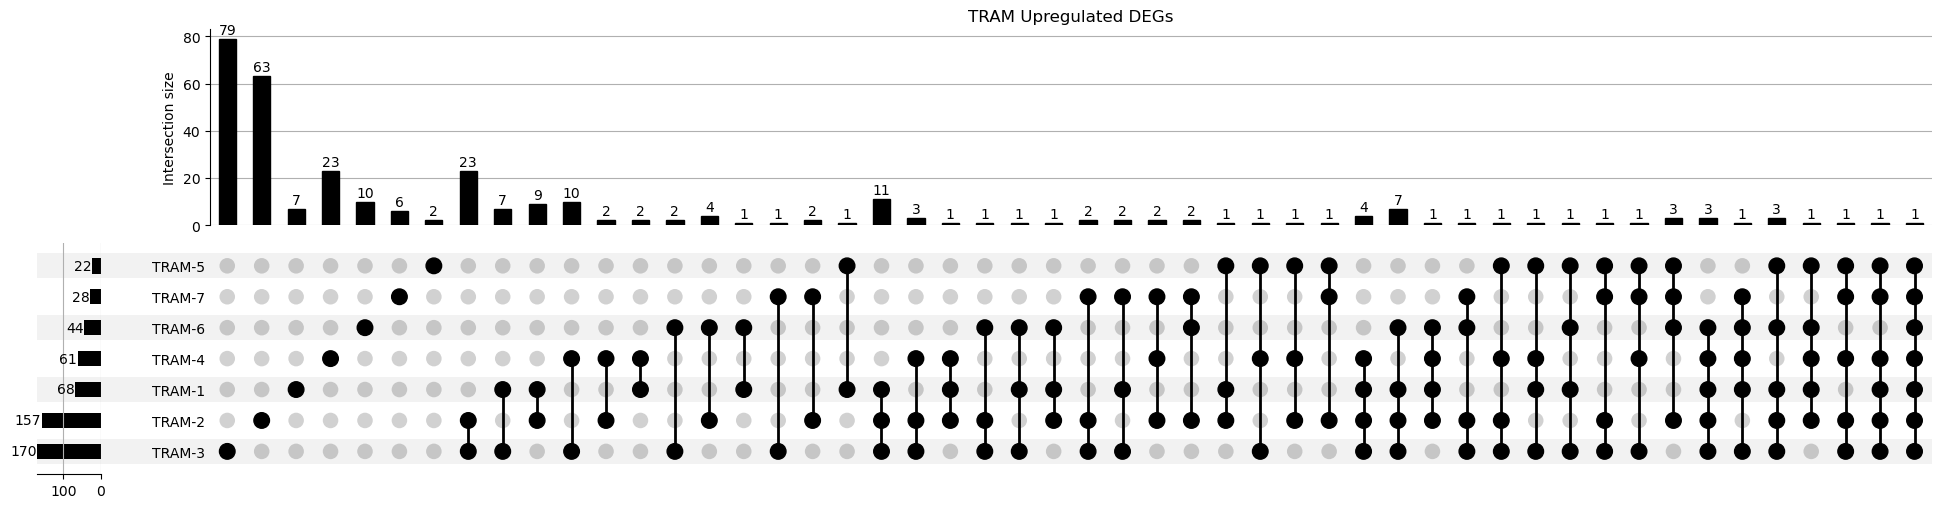

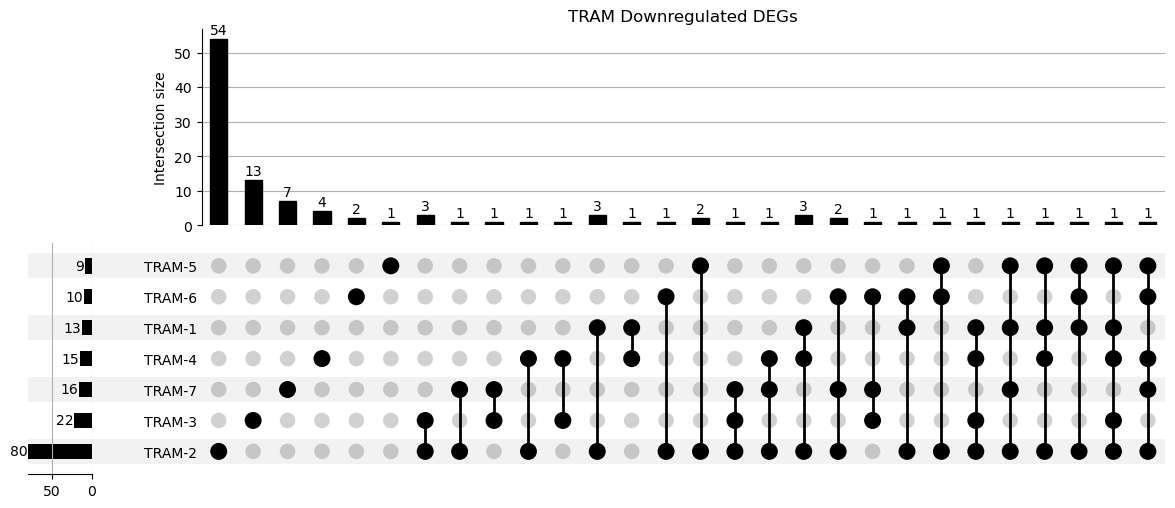

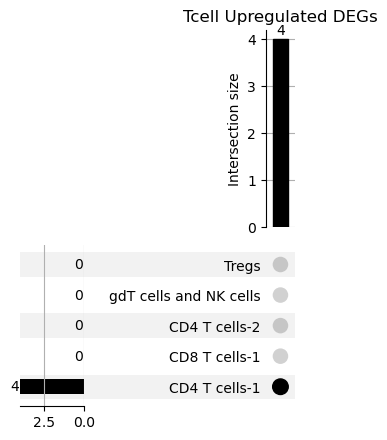

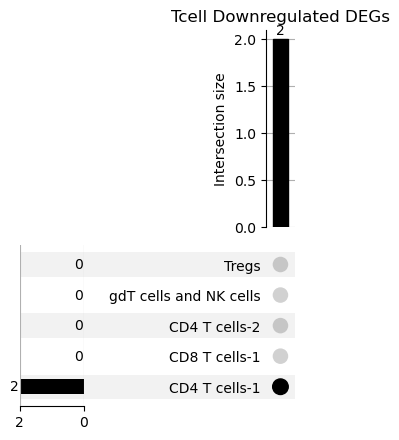

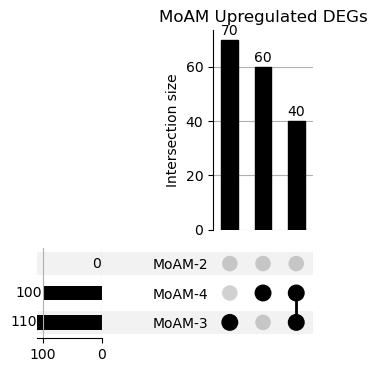

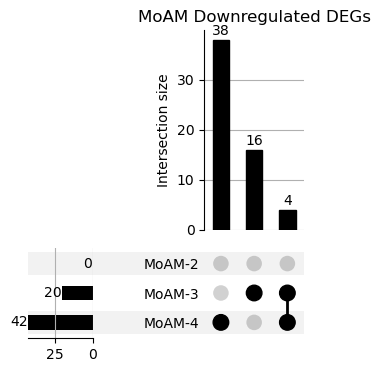

In [12]:
data = {}
for i in range(cell_map.shape[0]):
    cell_type = cell_map.file[i]    
    cell_dir = f"{data_dir}/01BAL/DEG/output/{cell_type}"
    if not os.path.exists(cell_dir):
        continue
    
    count_dir = f"{data_dir}/01BAL/DEG/counts/{cell_type}"
    meta = pd.read_csv(f"{count_dir}-meta.csv", index_col = 0)
    gene_cells = pd.read_csv(f"{count_dir}-n_cells.csv", sep = '\t', index_col = 0)
    cell_name = cell_map.type[cell_map.file == cell_type].tolist()[0]
    
    degs = pd.read_csv(f"{cell_dir}/degs.csv", index_col = 0)
    filtered_degs = pd.read_csv(f"{cell_dir}/filtered_degs.csv", index_col = 0)
    data[cell_map.type[i]] = {"meta": meta, "gene_cells": gene_cells, "degs": degs, "filtered_degs": filtered_degs}
    
make_upset_plots([x for x in data.keys() if "TRAM" in x], "TRAM")
make_upset_plots([x for x in data.keys() if "T cells" in x or x == "Tregs"], "Tcell")
make_upset_plots([x for x in data.keys() if "MoAM" in x], "MoAM")